Part 1 of the data analysis for section 2: Google Trend data collection and processing.

# Request Trend Data

In [1]:
import csv
import pandas as pd            
from pytrends.request import TrendReq
import time, os
from tenacity import retry, stop_after_attempt, wait_fixed

In [2]:
def csv_to_list(file_path):
    # Reading CSV into a list
    with open(file_path, newline='', encoding='utf-8') as file:
        reader = csv.reader(file)
        result = list(reader)[0]

    return [x.strip() for x in result]

In [3]:
# load data
left_NERs = csv_to_list('../data/NER_data/left_NER.csv')
right_NERs = csv_to_list('../data/NER_data/right_NER.csv')

In [4]:
pytrends = TrendReq()

def generate_fname(kwords, path):
    fname = path 
    for x in kwords:
        fname += x.replace(" ", "-") + "_"
    fname += 'trend.csv'

    return fname

@retry(stop=stop_after_attempt(5), wait=wait_fixed(60))
def download_trends(kwords, path):
    # construct file names
    fname = generate_fname(kwords, path)

    if os.path.exists(fname):
        print("existed: " + fname)
        return
    else:
        print(fname)

    pytrends.build_payload(kw_list=kwords, timeframe=['2022-01-01 2022-03-31'] * len(kwords), geo="US")
    df = pytrends.interest_over_time()
    df.to_csv(fname, index=False)

    # wait at least 5s, even for successful attempts
    time.sleep(5)

In [ ]:
# download inidivual trends
for x in left_NERs:
    download_trends([x], path = "../data/trend_data/one_NE/")

for x in right_NERs:
    download_trends([x], path = "../data/trend_data/one_NE/")

In [5]:
# download trends for two NE
def download_trend_for_multiple_NE(NE_lst, path, baseline_word):
    for NE in NE_lst:
        if NE == baseline_word:
            kwords = [NE]
        else:
            kwords = [NE, baseline_word]
        download_trends(kwords, path = path)

download_trend_for_multiple_NE(left_NERs, path = "../data/trend_data/Baseline_NE/left_trends/", baseline_word = "Democrat")
download_trend_for_multiple_NE(right_NERs, path = "../data/trend_data/Baseline_NE/right_trends/", baseline_word = "Republican")

existed: ../data/trend_data/Baseline_NE/left_trends/Biden_Democrat_trend.csv
existed: ../data/trend_data/Baseline_NE/left_trends/Democrat_trend.csv
existed: ../data/trend_data/Baseline_NE/left_trends/Pelosi_Democrat_trend.csv
existed: ../data/trend_data/Baseline_NE/left_trends/Democratic_Democrat_trend.csv
existed: ../data/trend_data/Baseline_NE/left_trends/Harris_Democrat_trend.csv
existed: ../data/trend_data/Baseline_NE/left_trends/Kamala-Harris_Democrat_trend.csv
existed: ../data/trend_data/Baseline_NE/left_trends/AOC_Democrat_trend.csv
existed: ../data/trend_data/Baseline_NE/left_trends/Dems_Democrat_trend.csv
existed: ../data/trend_data/Baseline_NE/left_trends/Blinken_Democrat_trend.csv
existed: ../data/trend_data/Baseline_NE/left_trends/Dem_Democrat_trend.csv
existed: ../data/trend_data/Baseline_NE/left_trends/Hillary-Clinton_Democrat_trend.csv
../data/trend_data/Baseline_NE/left_trends/Psaki_Democrat_trend.csv
../data/trend_data/Baseline_NE/left_trends/Biden-Administration_Democ

# process trend data for left and right NEs

In [9]:
import pandas as pd, numpy as np

In [60]:
def read_trend(kwords, path):
    fname = generate_fname(kwords, path)
    df = pd.read_csv(fname)

    # linearly interpolate 0 values to smooth the trend data
    df = df.drop(columns = ["isPartial"])
    df = df.replace(0, np.nan)    
    for column in df.columns:
        if pd.isna(df.at[0, column]):
            df.at[0, column] = 1

        df[column]= df[column].interpolate()

    return df

def calculate_relateive_weight(NE_lst, data_path, baseline_word):
    weighted_trend = [0] * 90

    # read the baseline
    baseline_trend = read_trend([baseline_word], data_path)[baseline_word]
    for NE in NE_lst:
        if NE == baseline_word:
            continue
            
        kwords = [NE, baseline_word]
        df = read_trend(kwords, data_path)
    
        # relative weight of second col to first col, mutiply the weight of first col to the data set
        ratio = df[NE] / df[baseline_word]

        # update the weighted_trend
        weighted_trend += ratio * baseline_trend
        
    # normalization
    weighted_trend /= max(weighted_trend)
    weighted_trend *= 100
    
    
    return weighted_trend

In [62]:
left_trend = calculate_relateive_weight(left_NERs, "../data/trend_data/Baseline_NE/left_trends/", "Democrat")
right_trend = calculate_relateive_weight(right_NERs, "../data/trend_data/Baseline_NE/right_trends/", "Republican")

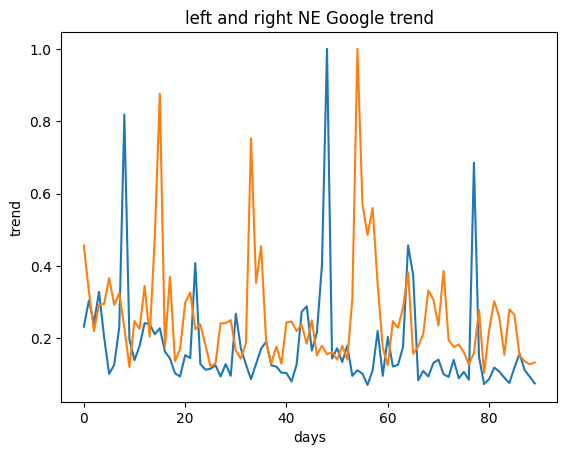

In [117]:
import numpy as np
import matplotlib.pyplot as plt

# Create a plot
plt.plot(left_trend)
plt.plot(right_trend)

plt.title('left and right NE Google trend')
plt.xlabel('days')
plt.ylabel('trend')

# Show the plot
plt.show()

In [121]:
df = pd.DataFrame([left_trend, right_trend]).transpose()
df.columns = ["Left", "Right"]

In [124]:
df.to_csv("../data/Google_weighted_trend.csv", index = False)